# 先尝试隐马尔可夫假设下通过MLP对时序数据进行预测

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

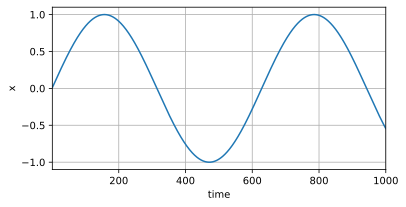

In [2]:
# 产生训练数据
T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01*time)
# x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))  # 对正弦信号加入噪音数据来增加预测难度
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [3]:
tau = 4  # τ = 4
# 制作数据集与标签, 代码十分精妙！
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练, 后续用于预测
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

In [4]:
print(torch.zeros((T - tau, tau)))
print('-'*50)
print(x[i: T - tau + i].shape)

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
--------------------------------------------------
torch.Size([996])


In [5]:
# 使用一个相当简单的架构训练模型： 一个拥有两个全连接层的多层感知机，ReLU激活函数和平方损失
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失
loss = nn.MSELoss(reduction='none')

In [6]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')
net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.012515
epoch 2, loss: 0.003711
epoch 3, loss: 0.003254
epoch 4, loss: 0.002798
epoch 5, loss: 0.002183


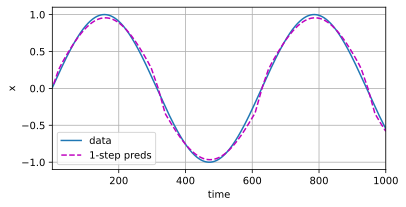

In [7]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

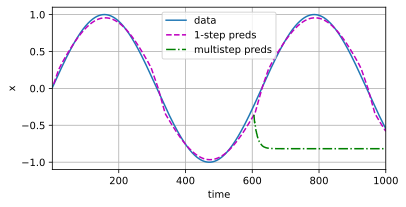

In [8]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

In [9]:
# 上图中可以看到：经过几个预测步骤之后，预测的结果很快就会衰减到一个常数。 
# 这是由于错误的累积导致的：假设在步骤 1 之后，我们积累了一些错误 ϵ1=ϵ¯ 。
# 于是，步骤 2 的输入被扰动了 ϵ1 ， 结果积累的误差是依照次序的 ϵ2=ϵ¯+cϵ1 ， 其中 c 为某个常数，后面的预测误差依此类推。
# 因此误差可能会相当快地偏离真实的观测结果

# 下面对RNN网络进行简单的复现

In [10]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [11]:
# 隐状态中 XtWxh+Ht−1Whh 的计算， 相当于 Xt 和 Ht−1 的拼接 与 Wxh 和 Whh 的拼接的矩阵乘法
# 虽然这个性质可以通过数学证明， 但在下面我们使用一个简单的代码来说明一下
X, W_xh = torch.normal(0, 1, (3, 1)), torch.normal(0, 1, (1, 4))
H, W_hh = torch.normal(0, 1, (3, 4)), torch.normal(0, 1, (4, 4))
torch.matmul(X, W_xh) + torch.matmul(H, W_hh)

tensor([[ 0.5476,  4.0118,  1.0409, -0.5163],
        [ 0.9600, -1.1200,  2.7284, -1.7254],
        [-0.8472, -0.3980,  0.9492, -4.0835]])

In [12]:
# 现在，沿列（轴1）拼接矩阵X和H， 沿行（轴0）拼接矩阵W_xh和W_hh
# 这两个拼接分别产生形状 (3,5) 和形状 (5,4) 的矩阵。 再将这两个拼接的矩阵相乘， 我们得到与上面相同形状 (3,4) 的输出矩阵
torch.matmul(torch.cat((X, H), 1), torch.cat((W_xh, W_hh), 0))

tensor([[ 0.5476,  4.0118,  1.0409, -0.5163],
        [ 0.9600, -1.1200,  2.7284, -1.7254],
        [-0.8472, -0.3980,  0.9492, -4.0835]])

In [13]:
# 先读取数据集《time machine》文本数据
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [14]:
print(len(vocab))  # 以char为单位, 共28类(a~z+<unk>+' ')

28


In [15]:
# 初始化模型参数
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_ho = normal((num_hiddens, num_outputs))
    b_o = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_ho, b_o]
    for param in params:
        param.requires_grad_(True)
    return params

In [16]:
# 初始化隐层参数并返回隐状态的函数
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )  # 返回tuple便于后续与lstm等网络进行代码复用

In [17]:
# 在一个时间步上完成隐状态的计算和输出, 类似前向计算的forward函数
def rnn(inputs, state, params):
    # inputs的形状：(时间步数量，批量大小，词表大小)
    W_xh, W_hh, b_h, W_ho, b_o = params
    H, = state
    outputs = []
    # X的形状：(批量大小，词表大小)
    for X in inputs:  # 在时间步数量维度上展开, X:[batch_size, vocab_size]
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)  # 使用tanh函数作为激活函数
        Y = torch.mm(H, W_ho) + b_o  # 当前时刻的输出
        outputs.append(Y)  # 所有的输出
    return torch.cat(outputs, dim=0), (H,)  # 返回结果([time_step×batch_size, vocab_size])和隐层状态

In [27]:
# 封装到一个类中去
class RNNModel: #@save
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [28]:
X = torch.arange(10).reshape((2, 5))
# 检查输出形状是否符合预期
num_hiddens = 512
net = RNNModel(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [31]:
# 预测函数
def predict(prefix, num_preds, net, vocab, device):  #@save
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))  # 取当前时刻最后的输出作为下一时刻的输入
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))  # 取可能性最大的char作为预测结果
    return ''.join([vocab.idx_to_token[i] for i in outputs])

# 未经训练的模型的预测结果
predict('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller hbja hb<unk>a '

In [32]:
# 梯度裁剪函数
def grad_clipping(net, theta):  #@save
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))  # 全局的均值
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [34]:
# 训练
#@save
def train_epoch(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

#@save
def train(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 1.0, 16184.4 词元/秒 cpu
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


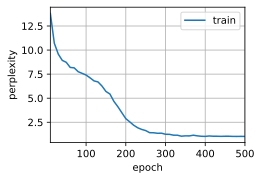

In [35]:
num_epochs, lr = 500, 1
train(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())